In [1]:
# librerie utilizzate
from my_functions import *    # funzioni "self-made"
import pandas as pd    # gestione dataframe
import numpy as np    # operazioni matematiche
from dateutil.parser import parse
from scipy import stats # calcolo del valore modale
#from sklearn.linear_model import LinearRegression
#from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV # selezione iperparametri del modello
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier # modelli Random Forest
from sklearn.metrics import mean_squared_log_error # funzione di score
from sklearn.model_selection import train_test_split # validazione
import matplotlib.pyplot as plt # funzioni grafiche

In [2]:
RANDOM_STATE = 42 # per avere risultati confrontabili

In [3]:
# lettura e salvataggio dei dati
train = pd.read_csv("/home/null/PycharmProjects/Miriade/data/raw_data/dataset_stima.csv")
test = pd.read_csv("/home/null/PycharmProjects/Miriade/data/raw_data/dataset_previsione.csv")
test_copy = test.copy(deep=True)

In [4]:
# drop delle osservazioni con var NUMERO_CLICK_SITO con valori negativi
train.drop(train[train.NUMERO_CLICK_SITO < 0].index, inplace=True)

In [5]:
# imputazione valore mediano alla variabile DATA per i valori mancanti
date_nulle = train.DATA.isnull()
date_non_nulle = [not i for i in date_nulle]

dates = list(train['DATA'][date_non_nulle].sort_values())
mediana_data = dates[len(dates)//2]
train.loc[date_nulle, 'DATA'] = mediana_data
#train['DATA'] = train['DATA'].apply(parse)

In [6]:
# gestione missing value per la variabile PUBBLICITA
moda_PUBBLICITA = stats.mode(train['PUBBLICITA'])
train['PUBBLICITA'] = train['PUBBLICITA'].fillna(int(moda_PUBBLICITA.mode))

In [7]:
# matrice delle correlazioni
corr_matrix = train.corr()
corr_matrix[np.abs(corr_matrix)<0.3] = 'low'

In [8]:
# gestione missing value per la variabile TIPO PUBBLICTA
tipo_nan = train['TIPO_PUBBLICITA'].isnull()
tipo_nonan = [not i for i in tipo_nan]

X_tipo = pd.concat([train['MACRO_TIPO_PUBBLICITA'].astype('category'),
                    train['FASCIA_ORARIA'].astype('category'),
                    train['FASCIA_TEMPISTICA'].astype('category'),
                    train['OFFERTA_PROMOZIONALE'].astype('category')], axis=1)

X_tipo = X_tipo.loc[train['TIPO_PUBBLICITA'][tipo_nonan].index]
y_tipo = train['TIPO_PUBBLICITA'][train['TIPO_PUBBLICITA'][tipo_nonan].index]

tipo_model = RandomForestClassifier(n_estimators=75, random_state=RANDOM_STATE)
tipo_model.fit(X_tipo, y_tipo)
X_tipo_test = pd.concat([train['MACRO_TIPO_PUBBLICITA'].astype('category'),
                    train['FASCIA_ORARIA'].astype('category'),
                    train['FASCIA_TEMPISTICA'].astype('category'),
                    train['OFFERTA_PROMOZIONALE'].astype('category')], axis=1)

test_tipo = X_tipo_test.loc[train['TIPO_PUBBLICITA'][tipo_nan].index]
tipo_pred = tipo_model.predict(test_tipo)
train.loc[tipo_nan, 'TIPO_PUBBLICITA'] = tipo_pred

In [9]:
# aggiustamento dtype per le variabili del dataset
train = fix_vars(train)
test = fix_vars(test)

In [10]:
## Aggiustamento variabili INIZIO_PUBBLICTA e FINE_PUBBLICITA
#train = fix_inizio_fine(train)
#test = fix_inizio_fine(test)

In [11]:
## Aggiustamento var DATA per rispettare i limiti delle var INIZIO_PUBBLICITA e FINE_PUBBLICITA
#train = fix_data_limit(train)
#test = fix_data_limit(test)

In [12]:
#train_ph = train.drop('NUMERO_CLICK_SITO', axis=1)
#dataset = pd.concat([train_ph, test], axis=0)

In [13]:
#codice_gioco_dummy = pd.get_dummies(dataset['CODICE_GIOCO'])

In [14]:
#nrows_train = train.shape[0]
#codice_gioco_dummy_train = codice_gioco_dummy.loc[:nrows_train, :]
#nrows_test = test.shape[0]
#nrows_train_plus_one = nrows_train+1
#codice_gioco_dummy_test = codice_gioco_dummy.loc[nrows_train_plus_one:nrows_test, :]

In [15]:
#train = pd.concat([train, codice_gioco_dummy_train], axis=1)
#test = pd.concat([test, codice_gioco_dummy_test], axis=1)

In [16]:
#codice_gioco_dummy_test = pd.get_dummies(test['CODICE_GIOCO'])
#test = pd.concat([test, codice_gioco_dummy_test], axis=1)

In [17]:
[(x,y) for x,y in zip(train.columns, range(len(train.columns)))]
#[(x,y) for x,y in zip(test.columns, range(len(test.columns)))]

[('PUBBLICITA', 0),
 ('INIZIO_PUBBLICITA', 1),
 ('FINE_PUBBLICITA', 2),
 ('MACRO_TIPO_PUBBLICITA', 3),
 ('FASCIA_ORARIA', 4),
 ('FASCIA_TEMPISTICA', 5),
 ('TIPO_PUBBLICITA', 6),
 ('DATA', 7),
 ('CODICE_GIOCO', 8),
 ('RILANCIO_PUBBLICITA', 9),
 ('SESSIONE', 10),
 ('NUMERO_CLICK_SITO', 11),
 ('OFFERTA_PROMOZIONALE', 12),
 ('MACRO_CATEGORIA_GIOCO', 13),
 ('MICRO_CATEGORIA_GIOCO', 14),
 ('AREA_CLICK', 15),
 ('NUMERO_PUBBLICITA_CONCORRENTI', 16),
 ('ID', 17)]

In [18]:
X = train.iloc[:, [0, 3, 4, 5, 6, 8, 9, 10, 12, 13, 14, 15, 16]] #rimosso 18, 19
y = train.iloc[:, 11]

X_test = test.iloc[:, [0, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]] #rimosso 17, 13, 18

In [19]:
# grid search

In [29]:
# validation

X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.85, test_size=0.15, random_state=RANDOM_STATE)

rf_model = RandomForestRegressor(n_estimators=75, n_jobs=-1, random_state=RANDOM_STATE)
rf_model.fit(X_train, y_train)
y_pred_validation = rf_model.predict(X_validation)

In [30]:
msle_validation = mean_squared_log_error(y_validation, y_pred_validation)
score_validation = score_fun(y_pred_validation, y_validation)             # 0.03728
print("score validation: ", score_validation, "\nmsle: ", msle_validation)

# score without new variables:
# score validation:  0.03991564709888681 
# msle:  0.0015932588833228653

score validation:  0.039887093327828686 
msle:  0.0015909802141429097


In [96]:
# tuning parametri Random Forest

# numero di features considerate ad ogni split
max_features = ['auto', 'sqrt']
# massimo numero di livelli di profondità degli alberi
max_depth = [int(x) for x in np.linspace(10, 110, num = 3)]
max_depth.append(None)
# dimensione minima del campione richiesta prima di ogni split
min_samples_split = [2, 5, 10]
# dimensione minima del campione richiesta in ogni foglia
min_samples_leaf = [5, 10]

param_grid = {'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

param_grid

{'max_depth': [10, 60, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [5, 10],
 'min_samples_split': [2, 5, 10]}

In [20]:
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2,
                           scoring='neg_mean_squared_log_error')

NameError: name 'param_grid' is not defined

In [99]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2 
[CV] max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2 
[CV] max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2 
[CV] max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, total=   2.5s
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, total=   2.5s
[CV] max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5 
[CV] max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5 
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, total=   2.5s
[CV]  max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, total=   2.5s
[CV] max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=10 
[CV] max

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   17.9s


[CV] max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, total=   1.0s
[CV] max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2 
[CV]  max_depth=10, max_features=sqrt, min_samples_leaf=10, min_samples_split=10, total=   0.9s
[CV] max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, total=   3.8s
[CV] max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, total=   3.8s
[CV] max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=5 
[CV]  max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=2, total=   4.4s
[CV] max_depth=60, max_features=auto, min_samples_leaf=5, min_samples_split=10 
[CV]  max_depth=60, max_features=auto, min_samples_

[CV] max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=5 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, total=   4.1s
[CV] max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=5 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, total=   4.0s
[CV] max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=5 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=2, total=   4.2s
[CV] max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=5, total=   4.1s
[CV] max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10 
[CV]  max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=5, total=   4.0s
[CV] max_depth=110, max_features=auto, min_samples_leaf=10, min_samples_split=10 
[CV]  max_depth=110, max_featur

[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=2, total=   1.3s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, total=   1.3s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10 
[CV]  max_depth=None, max_features=auto, min_samples_leaf=10, min_samples_split=10, total=   4.3s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, total=   1.4s
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, total=   1.3s
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10 
[CV] max_depth=None, max_features=sqrt, min_samples_leaf=10, min_samples_split=2 
[CV]  max_depth=None, max_features=sqrt, min_samples_leaf=5, min_samples_split=10, total=   1.3s
[CV] max_dep

[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  1.7min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 'sqrt'], 'max_depth': [10, 60, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_log_error', verbose=2)

In [100]:
grid_search.best_params_

{'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'min_samples_split': 5}

In [24]:
rf_model = RandomForestRegressor(n_estimators=150, n_jobs=-1,
                                 random_state=RANDOM_STATE, min_samples_split=5)

rf_model.fit(X, y)
yhat_rf = rf_model.predict(X_test)

In [39]:
df_grouped = raggruppa(test= test_copy, yhat= yhat_rf)
crea_file_submission(df_grouped, 30)

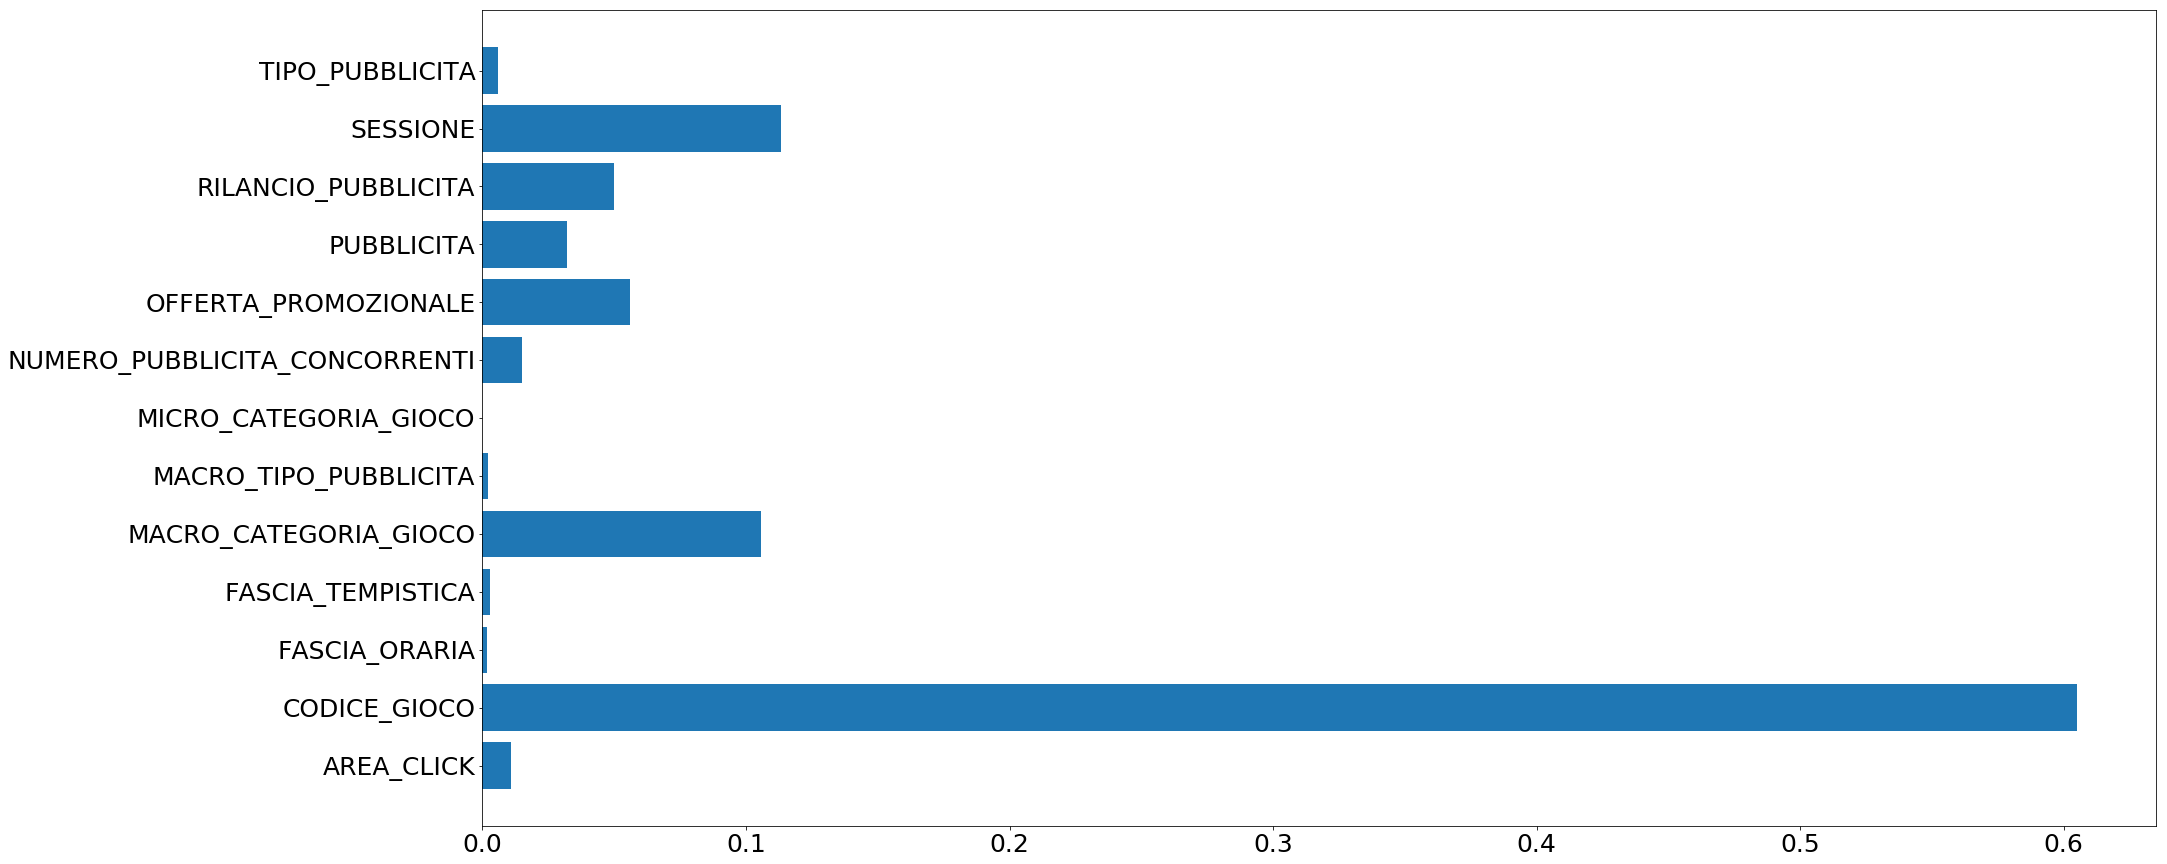

In [22]:
# plotting feature importances

var_label, var_importance = X.columns, rf_model.feature_importances_

plt.figure(figsize=(30,15))
plt.barh(var_label, var_importance)
plt.tick_params(labelsize=25)
plt.show()